In [1]:
import math
import numpy as np
import copy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
dataset_train = MNIST('data', train=True, download=True, transform=ToTensor())
dataset_test = MNIST('data', train=False, download=True, transform=ToTensor())

In [4]:
TRAIN_SIZE = 1500
VALID_SIZE = 250
TEST_SIZE = 250

BATCH_SIZE = 125

EPOCHS_MAX = 10
LEARNING_RATE = 0.0001

In [5]:
dataset_training = torch.utils.data.Subset(dataset_train, range(0, TRAIN_SIZE))
dataset_validating = torch.utils.data.Subset(dataset_test, range(0, VALID_SIZE))
dataset_testing = torch.utils.data.Subset(dataset_test, range(VALID_SIZE, VALID_SIZE + TEST_SIZE))

dataloader_train = DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(dataset_validating, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_testing, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def compute_accuracy(model, data_loader):
    
    correct_pred = 0
    num_examples = 0
    
    for i, (features, targets) in enumerate(data_loader):

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100

In [7]:
class signSGD(optim.Optimizer):

    def __init__(self, params, lr=0.01):
        
        defaults = dict(lr=lr)

        super(signSGD, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:
            
            for p in group['params']:
                
                if p.grad != None:
                    p.data -= group['lr'] * torch.sign(p.grad)

In [8]:
# Inspired by https://github.com/jxbz/signSGD

class signumSGD(optim.Optimizer):

    def __init__(self, params, lr=0.001, beta=0.9):
        
        defaults = dict(lr=lr)
        self.beta = beta
        self.momentum = None
        
        super(signumSGD, self).__init__(params, defaults)

    def step(self):

        if self.momentum == None:
            self.momentum = [None for group in self.param_groups]

        for i, group in enumerate(self.param_groups):
            
            if self.momentum[i] == None:
                self.momentum[i] = [torch.zeros(p.size()) for p in group["params"]]
            
            for j, p in enumerate(group['params']):
                
                if p.grad != None:
                    
                    self.momentum[i][j] = self.beta * self.momentum[i][j] + (1 - self.beta) * p.grad
                    
                    p.data -= group['lr'] * torch.sign(self.momentum[i][j])

In [9]:
# RESNET-18 from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        
        self.inplanes = 64
        in_dim = 1
        
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        
        downsample = None
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas

def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes)
    return model

In [10]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs):
    
    losses = []
    accs = []
    
    for ep in range(epochs):
        
        model.train()
        
        for it, batch in enumerate(dataloader_train):
            
            x, y = batch
            
            logits, probas = model.forward(x)
            
            loss = criterion(logits, y)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        
        with torch.no_grad():
            
            acc = compute_accuracy(model, dataloader_test)
            
        print("\r Epoch {}/{} | Loss = {:.2f} & Acc = {:.1f}".format(ep+1, epochs, float(loss), acc), end='')

        losses.append(float(loss))
        accs.append(acc)
        
    print("")
            
    return losses, accs

In [11]:
def train_sign(epochs, learning_rate):
    
    model = resnet18(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = signSGD(model.parameters(), lr=learning_rate)

    losses, accs = train_model(model, criterion, optimizer, dataloader_train, dataloader_valid, epochs)
    
    return losses, accs

In [12]:
def ploting_sign(lrs, nb_tests, nb_epochs=EPOCHS_MAX):
    
    lrs.sort()
    
    all_accs = []
    
    for lr in lrs:
        
        print("Learning Rate =", lr)
        
        accs = []
        
        for _ in range(nb_tests):
        
            _, temp_accs = train_sign(nb_epochs, lr)
            accs.append(temp_accs[-1])
    
        all_accs.append(np.median(accs))
        
    plt.figure(figsize=(15,10))

    plt.plot(lrs, all_accs)
    
    plt.title("SignSGD")

    plt.ylabel("Accuracy (%)")
    plt.xlabel("Learning rate")

    plt.xscale('log')
    
    plt.show()
    
    return all_accs

In [13]:
def train_signum(epochs, beta, learning_rate=LEARNING_RATE):
    
    model = resnet18(10)
    criterion = nn.CrossEntropyLoss()
    optimizer = signumSGD(model.parameters(), lr=learning_rate, beta=beta)

    losses, accs = train_model(model, criterion, optimizer, dataloader_train, dataloader_valid, epochs)
    
    return losses, accs

In [14]:
def ploting_signum(betas, nb_tests, nb_epochs=EPOCHS_MAX, learning_rate=LEARNING_RATE):
    
    betas.sort()
    
    all_accs = []
    
    for beta in betas:
        
        print("Béta =", beta)
        
        accs = []
        
        for _ in range(nb_tests):
        
            _, temp_accs = train_signum(nb_epochs, beta, learning_rate=learning_rate)
            accs.append(temp_accs[-1])
    
        all_accs.append(np.median(accs))
        
    plt.figure(figsize=(15,10))

    plt.plot(betas, all_accs)
    
    plt.title("SignumSGD")

    plt.ylabel("Accuracy (%)")
    plt.xlabel("Béta")
    
    plt.grid()

    plt.show()
    
    return all_accs

Learning Rate = 1000
 Epoch 10/10 | Loss = 53863624.00 & Acc = 17.0
 Epoch 10/10 | Loss = 173133104.00 & Acc = 70.5
 Epoch 10/10 | Loss = 601625536.00 & Acc = 8.5
 Epoch 10/10 | Loss = 626708800.00 & Acc = 61.5
 Epoch 10/10 | Loss = 753339968.00 & Acc = 54.0
 Epoch 10/10 | Loss = 103571376.00 & Acc = 56.5
 Epoch 10/10 | Loss = 76724520.00 & Acc = 24.5
 Epoch 10/10 | Loss = 53557856.00 & Acc = 46.0
 Epoch 10/10 | Loss = 182223408.00 & Acc = 33.5
 Epoch 10/10 | Loss = 288298336.00 & Acc = 63.5
Learning Rate = 100
 Epoch 10/10 | Loss = 1920697.62 & Acc = 66.5
 Epoch 10/10 | Loss = 2360994.25 & Acc = 47.5
 Epoch 10/10 | Loss = 526427.38 & Acc = 14.05
 Epoch 10/10 | Loss = 1586836.50 & Acc = 27.0
 Epoch 10/10 | Loss = 1864910.62 & Acc = 29.0
 Epoch 10/10 | Loss = 1050620.75 & Acc = 37.0
 Epoch 10/10 | Loss = 2367515.25 & Acc = 42.0
 Epoch 10/10 | Loss = 3436946.75 & Acc = 53.0
 Epoch 10/10 | Loss = 1294872.75 & Acc = 59.0
 Epoch 10/10 | Loss = 11444638.00 & Acc = 70.5
Learning Rate = 10
 Ep

[50.0, 44.75, 54.5, 48.0, 61.25, 85.5, 92.5, 94.0]

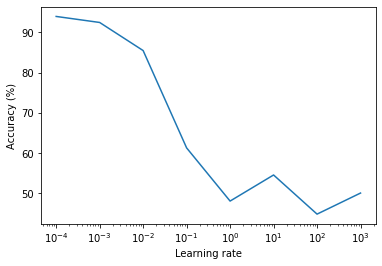

In [14]:
lrs = [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

ploting_sign(lrs, 10)

Learning Rate = 1e-05
 Epoch 10/10 | Loss = 0.57 & Acc = 78.0
 Epoch 10/10 | Loss = 0.48 & Acc = 77.0
 Epoch 10/10 | Loss = 0.52 & Acc = 79.5
Learning Rate = 5e-05
 Epoch 10/10 | Loss = 0.00 & Acc = 91.0
 Epoch 10/10 | Loss = 0.00 & Acc = 92.0
 Epoch 10/10 | Loss = 0.00 & Acc = 97.5
Learning Rate = 0.0001
 Epoch 10/10 | Loss = 0.00 & Acc = 96.0
 Epoch 10/10 | Loss = 0.00 & Acc = 96.5
 Epoch 10/10 | Loss = 0.00 & Acc = 95.0
Learning Rate = 0.0005
 Epoch 10/10 | Loss = 0.07 & Acc = 92.5
 Epoch 10/10 | Loss = 0.06 & Acc = 89.5
 Epoch 10/10 | Loss = 0.02 & Acc = 86.0
Learning Rate = 0.001
 Epoch 10/10 | Loss = 0.29 & Acc = 88.5
 Epoch 10/10 | Loss = 0.10 & Acc = 96.5
 Epoch 10/10 | Loss = 0.11 & Acc = 94.5


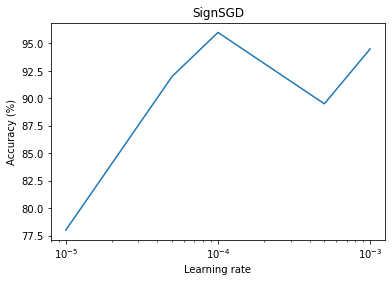

[78.0, 92.0, 96.0, 89.5, 94.5]

In [27]:
lrs = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]
ploting_sign(lrs, 3)

Béta = 0
 Epoch 10/10 | Loss = 0.00 & Acc = 97.0
 Epoch 10/10 | Loss = 0.00 & Acc = 94.5
 Epoch 10/10 | Loss = 0.00 & Acc = 97.0
 Epoch 10/10 | Loss = 0.00 & Acc = 96.0
 Epoch 10/10 | Loss = 0.00 & Acc = 95.5
 Epoch 10/10 | Loss = 0.00 & Acc = 94.0
 Epoch 10/10 | Loss = 0.00 & Acc = 96.0
 Epoch 10/10 | Loss = 0.00 & Acc = 94.0
 Epoch 10/10 | Loss = 0.00 & Acc = 95.0
 Epoch 10/10 | Loss = 0.00 & Acc = 92.0
Béta = 0.1
 Epoch 10/10 | Loss = 0.00 & Acc = 96.5
 Epoch 10/10 | Loss = 0.00 & Acc = 95.0
 Epoch 10/10 | Loss = 0.00 & Acc = 93.5
 Epoch 10/10 | Loss = 0.00 & Acc = 93.5
 Epoch 10/10 | Loss = 0.00 & Acc = 91.0
 Epoch 10/10 | Loss = 0.00 & Acc = 93.0
 Epoch 10/10 | Loss = 0.00 & Acc = 95.0
 Epoch 10/10 | Loss = 0.00 & Acc = 93.5
 Epoch 10/10 | Loss = 0.00 & Acc = 93.5
 Epoch 10/10 | Loss = 0.00 & Acc = 94.5
Béta = 0.2
 Epoch 10/10 | Loss = 0.01 & Acc = 95.5
 Epoch 10/10 | Loss = 0.00 & Acc = 95.5
 Epoch 10/10 | Loss = 0.00 & Acc = 92.5
 Epoch 10/10 | Loss = 0.00 & Acc = 93.5
 Epoch 10

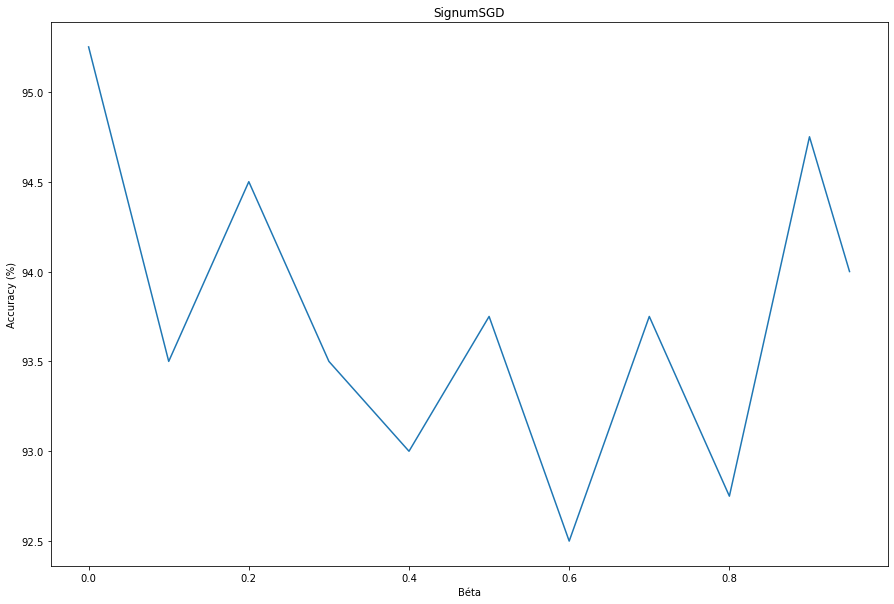

[95.25, 93.5, 94.5, 93.5, 93.0, 93.75, 92.5, 93.75, 92.75, 94.75, 94.0]

In [43]:
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ploting_signum(betas, 10)